In [1]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve

import warnings
warnings.filterwarnings("ignore");

RAND = 10

In [2]:
df = pd.read_csv('/Users/mars/Desktop/Finbridge tt/train.csv')

In [3]:
df = df.drop(df.columns[[0]], axis = 1)

In [4]:
df = df.drop(['customer_ID', 'S_2', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'], axis=1)

In [5]:
df = df.fillna(df.mean())

In [6]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, shuffle=True, random_state=RAND)

In [7]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_score = lr.predict_proba(X_test)[:,1]

In [8]:
y_score

array([0.95247198, 0.99981515, 0.00363107, ..., 0.01793041, 0.01394754,
       0.54390267])

In [9]:
print('roc-auc:', roc_auc_score(y_test, y_score))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('logloss:', log_loss(y_test, y_pred))

roc-auc: 0.9549464186063622
precision: 0.8129697605313756
recall: 0.7764283627561454
f1: 0.7942790052300139
logloss: 3.6109875501177675


In [10]:
metrics = pd.DataFrame(
    index=['roc-auc', 'precision', 'recall', 'f1', 'logloss'])

metrics['Baseline_LR'] = [roc_auc_score(y_test, y_score),
                          precision_score(y_test, y_pred),
                          recall_score(y_test, y_pred),
                          f1_score(y_test, y_pred),
                          log_loss(y_test, y_pred)]

In [11]:
metrics

,Baseline_LR
roc-auc,0.954946
precision,0.812970
recall,0.776428
f1,0.794279
logloss,3.610988


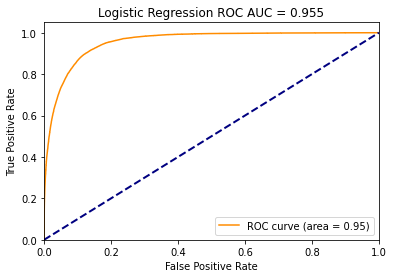

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [13]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(1, 1000, num=5),
    'solver': ['sag', 'saga', 'lbfgs'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': np.arange(100, 500, 100)
}

lr = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='roc_auc', cv=cv, verbose=2)

In [14]:
# производим обучение по сетке (долго)
#grid_cv.fit(X_train, y_train)

In [15]:
#print(grid_cv.best_score_)
#print(grid_cv.best_params_)

In [16]:
best_params = {'C': 1.0, 
               'l1_ratio': 0.25,
               'max_iter': 400, 
               'penalty': 'l2', 
               'solver': 'lbfgs'}

In [17]:
lr_gr = LogisticRegression(**best_params, class_weight='balanced')
lr_gr.fit(X_train, y_train)

y_pred_gr = lr_gr.predict(X_test)
y_score_gr = lr_gr.predict_proba(X_test)[:,1]

In [18]:
y_score_gr

array([0.98343276, 0.99996761, 0.00906988, ..., 0.03792321, 0.03601689,
       0.78567282])

In [19]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.9550553643518782
precision: 0.7181158938194399
recall: 0.9009640666082384
f1: 0.7992151491031598
logloss: 4.064406727681439


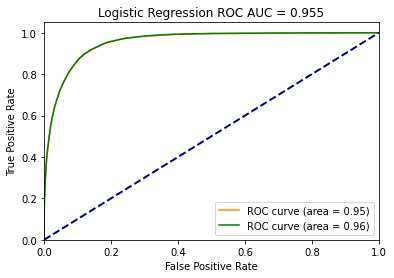

In [20]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_score_gr)

roc_auc_2 = auc(fpr_2, tpr_2)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_2, tpr_2, color='green', label='ROC curve (area = %0.2f)' % roc_auc_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [21]:
metrics['Grid_LR'] = [roc_auc_score(y_test, y_score_gr),
                      precision_score(y_test, y_pred_gr),
                      recall_score(y_test, y_pred_gr),
                      f1_score(y_test, y_pred_gr),
                      log_loss(y_test, y_pred_gr)]

In [22]:
metrics[:-1].style.highlight_max(axis=1, color='lightblue')

,Baseline_LR,Grid_LR
roc-auc,0.954946,0.955055
precision,0.812970,0.718116
recall,0.776428,0.900964
f1,0.794279,0.799215


In [23]:
import shap

In [24]:
explainer = shap.LinearExplainer(lr_gr, X_train, feature_dependence="independent")
shap_values = explainer(X_test)

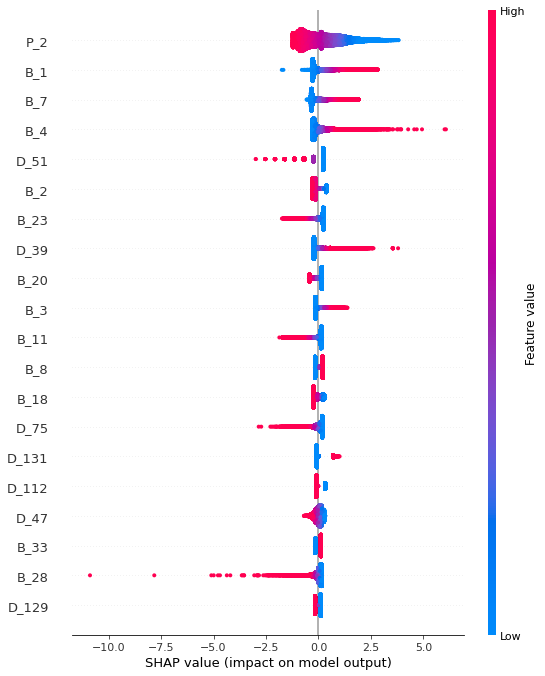

In [25]:
# summary plot
shap.summary_plot(shap_values, X_test)

In [26]:
df_test = pd.read_csv('/Users/mars/Desktop/Finbridge tt/test_fb.csv')

In [27]:
cust_id = df_test['customer_ID']

In [28]:
df_test = df_test.drop(df_test.columns[[0]], axis = 1)

In [29]:
df_test

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-29,0.6216,0.001082,0.012566,1.0060,0.007830,0.28780,0.004530,0.009940,...,NaN,NaN,NaN,0.002705,0.006184,0.001899,NaN,0.008190,0.005558,0.002983
1,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-30,0.8720,0.005573,0.007680,0.8160,0.001247,NaN,0.000231,0.005527,...,NaN,NaN,NaN,0.002974,0.004160,0.005764,NaN,0.008156,0.006943,0.000905
2,00018dd4932409baf6083519b52113c2ef58be59e1213e...,2018-03-26,0.8945,0.007793,0.017900,0.8120,0.007027,0.09710,0.008310,0.009980,...,NaN,NaN,NaN,0.004284,0.006910,0.007717,NaN,0.004930,0.008560,0.004406
3,000198b3dc70edd65dbf0d7eddbcb926c6d7dbd7986af1...,2018-03-28,0.5273,0.360400,0.041720,0.6733,0.006730,0.83900,0.001353,0.049040,...,NaN,NaN,NaN,1.006000,0.005123,0.888700,0.1913,1.010000,0.670400,0.186800
4,00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b7...,2018-03-27,0.8280,0.120240,0.027310,1.0020,0.001572,0.17580,0.006530,0.019490,...,NaN,NaN,NaN,1.005000,0.000700,0.890600,0.1610,1.003000,0.509000,0.093600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90198,fffc59f2e1aa4de05de451121a35c26c61e63cfc38328a...,2018-03-28,0.9110,0.009670,0.006474,0.8190,0.001778,NaN,0.005140,0.009926,...,NaN,NaN,NaN,0.009670,0.009190,0.004960,NaN,0.006645,0.000382,0.007156
90199,fffd1a37da07c54a930788ab53061cd7bd34d38592205e...,2018-03-30,0.8340,0.003370,0.003210,0.8140,0.009575,NaN,0.002268,0.002842,...,NaN,NaN,NaN,0.000321,0.009250,0.003960,NaN,0.004086,0.009834,0.007088
90200,fffdc0cf228085b4275b38ebe6eb915766af3fecb2ae28...,2018-03-30,0.9810,0.120800,0.034000,1.0060,0.009260,0.04297,0.007523,0.015144,...,NaN,NaN,NaN,0.009094,0.009410,0.006970,NaN,0.001828,0.003752,0.007240
90201,fffe39594fad367d9eb8ae18537b56b0739c4cc3ab9810...,2018-03-27,0.1511,0.004130,0.216100,0.0400,0.504000,0.28150,0.007412,0.526000,...,NaN,NaN,NaN,0.008880,0.004110,0.004154,NaN,0.007748,0.006577,0.006187


In [30]:
df_test = df_test.drop(['customer_ID', 'S_2', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'], axis=1)

In [31]:
df_test = df_test.fillna(df.mean())

In [32]:
X_tr = df.drop('target', axis=1)
Y_tr = df['target']

In [33]:
lr_gr = LogisticRegression(**best_params, class_weight='balanced')
lr_gr.fit(X_tr, Y_tr)

y_pred_gr_test = lr_gr.predict(df_test)
y_score_gr_test = lr_gr.predict_proba(df_test)[:,1]

In [34]:
cust_id

0        000041bdba6ecadd89a52d11886e8eaaec9325906c9723...
1        00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...
2        00018dd4932409baf6083519b52113c2ef58be59e1213e...
3        000198b3dc70edd65dbf0d7eddbcb926c6d7dbd7986af1...
4        00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b7...
                               ...                        
90198    fffc59f2e1aa4de05de451121a35c26c61e63cfc38328a...
90199    fffd1a37da07c54a930788ab53061cd7bd34d38592205e...
90200    fffdc0cf228085b4275b38ebe6eb915766af3fecb2ae28...
90201    fffe39594fad367d9eb8ae18537b56b0739c4cc3ab9810...
90202    ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...
Name: customer_ID, Length: 90203, dtype: object

In [35]:
len(y_score_gr_test)

90203

In [36]:
result = pd.DataFrame(cust_id)

In [38]:
result['score'] = y_score_gr_test

In [39]:
result

,customer_ID,score
0,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.039938
1,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.037130
2,00018dd4932409baf6083519b52113c2ef58be59e1213e...,0.009771
3,000198b3dc70edd65dbf0d7eddbcb926c6d7dbd7986af1...,0.422923
4,00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b7...,0.071476
...,...,...
90198,fffc59f2e1aa4de05de451121a35c26c61e63cfc38328a...,0.016262
90199,fffd1a37da07c54a930788ab53061cd7bd34d38592205e...,0.014983
90200,fffdc0cf228085b4275b38ebe6eb915766af3fecb2ae28...,0.000576
90201,fffe39594fad367d9eb8ae18537b56b0739c4cc3ab9810...,0.953429


In [40]:
result.to_csv('result_fb.csv')